In [71]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../utils/")
sys.path.append("../")
from torch.utils.data import DataLoader
from utils import MyDataset, Normalize
from tqdm import tqdm
from networks.allaire_net import Allaire_Net
from networks.conv_net import Conv_Net
from networks.conv_net_2 import Conv_Net2
from networks.unet import U_Net
from networks.utils import EarlyStopper
import json
import argparse
import os
import pathlib
import numpy.ma as ma
import csv

In [2]:
transform = Normalize(root="../../data")
dataset = MyDataset(root="../../data", tform=transform)
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = torch.utils.data.DataLoader(train_dataset)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

In [76]:
fuel_t = {}
with open('./spain_lookup_table.csv', mode='r') as infile:
    reader = csv.reader(infile)
    i = 0
    for row in reader:
        fuel_t[row[0]] = row[3]
        i+=1
fuel_t['141'] = 'Non-fuel'
f = open('./biomass.json')
biomass_t = json.load(f)
f.close()

In [115]:
fuel_t

{'grid_value': 'fuel_type',
 '101': 'GR1',
 '102': 'GR2',
 '103': 'GR3',
 '104': 'GR4',
 '105': 'GR5',
 '106': 'GR6',
 '107': 'GR7',
 '108': 'GR8',
 '121': 'GS1',
 '122': 'GS2',
 '123': 'GS3',
 '124': 'GS4',
 '142': 'SH2',
 '143': 'SH3',
 '144': 'SH4',
 '145': 'SH5',
 '146': 'SH6',
 '147': 'SH7',
 '148': 'SH8',
 '149': 'SH9',
 '161': 'TU1',
 '162': 'TU2',
 '163': 'TU3',
 '164': 'TU4',
 '165': 'TU5',
 '181': 'TL1',
 '182': 'TL2',
 '183': 'TL3',
 '185': 'TL5',
 '186': 'TL6',
 '188': 'TL8',
 '189': 'TL9',
 '0': 'Non-fuel',
 '91': 'Non-fuel',
 '92': 'Non-fuel',
 '93': 'Non-fuel',
 '98': 'Non-fuel',
 '99': 'Non-fuel',
 '141': 'Non-fuel'}

In [112]:
fuels = []
arqueo = []
cbd = []
cbh = []
elevation = []
flora = []
paleo = []
urban = []
importance = 0.7
FOLDER = pathlib.Path("./attention_maps/ewes")
for item in tqdm(FOLDER.iterdir()):
    fire_number = item.name.split("-")[0]
    file = np.load(f'../../data/backgrounds_400/background_{fire_number}.npz')
    topology = np.concatenate([np.expand_dims(file["a1"], axis=0), np.expand_dims(file["a2"], axis=0), np.expand_dims(file["a3"], axis=0)
                                , np.expand_dims(file["a4"], axis=0), np.expand_dims(file["a5"], axis=0), 
                                np.expand_dims(file["a6"], axis=0), np.expand_dims(file["a7"], axis=0), 
                                np.expand_dims(file["a8"], axis=0)])
    topology = np.where(topology == -9999.0, -1, topology)
    map = plt.imread(f"./attention_maps/ewes/{item.name}")
    filtered = np.where(map >= importance, 0, 1)
    mx = ma.masked_array(topology, mask=np.stack([filtered]*8, axis=0))
    # Biomass:
    cbd.append(mx[2].data[np.logical_not(mx[2].mask)].tolist())
    cbh.append(mx[3].data[np.logical_not(mx[3].mask)].tolist())
    fuels.append(mx[0].data[np.logical_not(mx[0].mask)].tolist())
    arqueo.append(mx[1].data[np.logical_not(mx[1].mask)].tolist())
    elevation.append(mx[4].data[np.logical_not(mx[0].mask)].tolist())
    flora.append(mx[5].data[np.logical_not(mx[5].mask)].tolist())
    paleo.append(mx[6].data[np.logical_not(mx[6].mask)].tolist())
height = [(x + 1.201) / (1 - 0.391) - x for x in cbh[0]] # mts
volume = 80 * 80 * height
canopy_biomass = [x * y for x, y in zip(volume, cbd[0])] # kilograms in 6400 m²
canopy_biomass = [x / 6400 for x in canopy_biomass] # kg / m²
canopy_biomass = [x * 10 for x in canopy_biomass] # ton / hect
total_biomass = [biomass_t[fuel_t[str[int[x]]]]["1-hr"] + biomass_t[fuel_t[str[int[x]]]]["10-hr"] + biomass_t[fuel_t[str[int[x]]]]["100-hr"] + biomass_t[fuel_t[str[int[x]]]]["Live Herb"] for x in fuels[0] if x != -1]
fine_biomass = [biomass_t[x]["1-hr"] + biomass_t[x]["10-hr"] for x in fuels[0] if x != -1]
live_herb = [biomass_t[x]["Live Herb"] for x in fuels[0] if x != -1]
    

111it [00:03, 33.79it/s]


KeyboardInterrupt: 

In [114]:
height = [(x + 1.201) / (1 - 0.391) - x for x in cbh[0]] # mts
volume = 80 * 80 * height
canopy_biomass = [x * y for x, y in zip(volume, cbd[0])] # kilograms in 6400 m²
canopy_biomass = [x / 6400 for x in canopy_biomass] # kg / m²
canopy_biomass = [x * 10 for x in canopy_biomass] # ton / hect
total_biomass = [biomass_t[str(int(x))]["1-hr"] + biomass_t[str(int(x))]["10-hr"] + biomass_t[str(int(x))]["100-hr"] + biomass_t[str(int(x))]["Live Herb"] for x in fuels[0] if x != -1]
fine_biomass = [biomass_t[x]["1-hr"] + biomass_t[x]["10-hr"] for x in fuels[0] if x != -1]
live_herb = [biomass_t[x]["Live Herb"] for x in fuels[0] if x != -1]

KeyError: '123'

{'whiskers': [<matplotlib.lines.Line2D at 0x7f137757ecd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f137757f3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f13749f7a10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f137757d750>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f137757c450>],
 'means': []}

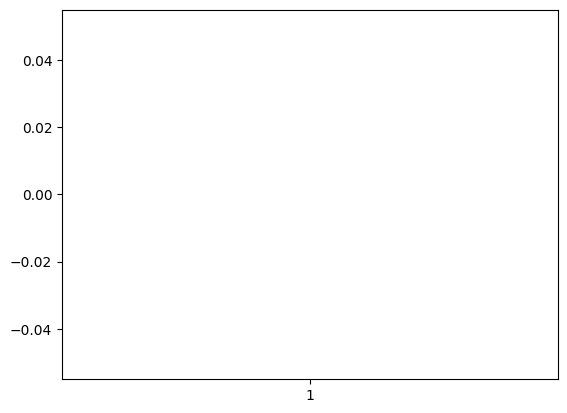

In [99]:
plt.boxplot(total_biomass)

TypeError: Invalid shape (268,) for image data

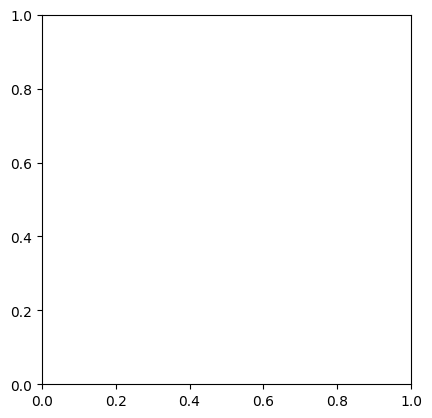

In [109]:
plt.imshow(mx[1].data[np.logical_not(mx[0].mask))
plt.colorbar()

In [111]:
mx[1].data[np.logical_not(mx[1].mask)]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [108]:
mx.mask

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [46]:
mx[3].data[np.logical_not(mx[0].mask)].tolist()

[1.1402568817138672,
 0.5174118876457214,
 2.175318717956543,
 1.6863744258880615,
 2.2601981163024902,
 0.9587781429290771,
 2.2392637729644775,
 2.1945881843566895,
 1.7876205444335938,
 3.968966245651245,
 2.4411537647247314,
 2.482023000717163,
 1.9858468770980835,
 2.5593693256378174,
 2.1715919971466064,
 2.7416093349456787,
 0.0,
 1.243866205215454,
 2.9839086532592773,
 1.845935583114624,
 1.6896986961364746,
 0.4714356064796448,
 2.3392887115478516,
 2.671574354171753,
 2.2028162479400635,
 0.0,
 1.3421000242233276,
 1.225950002670288,
 1.8291000127792358,
 1.471850037574768,
 1.6951500177383423,
 2.1175498962402344,
 1.948099970817566,
 2.59802508354187,
 1.3844000101089478,
 1.455275058746338,
 0.7534193992614746,
 1.8524937629699707,
 1.5813250541687012,
 1.987975001335144,
 0.43545001745224,
 0.42465001344680786,
 0.6820712685585022,
 1.8979381322860718,
 3.269218683242798,
 2.385946750640869,
 2.8236656188964844,
 2.3103256225585938,
 3.1694154739379883,
 2.51321816444396